In [1]:
import matplotlib.image as img
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
from os.path import isfile, join
from patchify import patchify
import os
import imageio

# Short summary:

We first loaded in the images, converting the tif and JPG files to numpy matrices. Since we had a low sample of images to work with, we patched the images using a step size of 128, with each patch containing roughly 15% of the original image, resulting in a (350,525,3) image. Since our Swin transformer is trained on (224,224,3) images, we then resized our patches to match our expected input. We also normalize our patches to reduce the likelihood that we run into any vanishing/exploding gradients.

In [4]:
!pip install imagecodecs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 10.1 MB/s eta 0:00:0000:0100:01


In [2]:
images_dir = 'images'
seg_dir = 'manual1'
mask_dir = 'mask'

# List all files in the directories
image_files = sorted(os.listdir(images_dir))
seg_files = sorted(os.listdir(seg_dir))
mask_files = sorted(os.listdir(mask_dir))
def load_images_from_folder(folder, file_names):
    images = []
    labels = []
    for filename in file_names:
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = imageio.imread(img_path)
            images.append(img)
        if filename.split('.')[0].endswith('h'):
            labels.append(0)
        else:
            labels.append(1)
    return images, labels

# Load the images and masks
images, label_images = load_images_from_folder(images_dir, image_files)
masks, label_masks = load_images_from_folder(mask_dir, mask_files)
vessels, label_vessels = load_images_from_folder(seg_dir, seg_files)

/var/folders/k5/7nk1477d5z3bkqm2lvczvt000000gn/T/ipykernel_81687/3674857059.py:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [3]:
label_images

[1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0]

In [4]:
image_files

['01_dr.JPG',
 '01_g.jpg',
 '01_h.jpg',
 '02_dr.JPG',
 '02_g.jpg',
 '02_h.jpg',
 '03_dr.JPG',
 '03_g.jpg',
 '03_h.jpg',
 '04_dr.JPG',
 '04_g.jpg',
 '04_h.jpg',
 '05_dr.JPG',
 '05_g.jpg',
 '05_h.jpg',
 '06_dr.JPG',
 '06_g.jpg',
 '06_h.jpg',
 '07_dr.JPG',
 '07_g.jpg',
 '07_h.jpg',
 '08_dr.JPG',
 '08_g.jpg',
 '08_h.jpg',
 '09_dr.JPG',
 '09_g.jpg',
 '09_h.jpg',
 '10_dr.JPG',
 '10_g.jpg',
 '10_h.jpg',
 '11_dr.JPG',
 '11_g.jpg',
 '11_h.jpg',
 '12_dr.JPG',
 '12_g.jpg',
 '12_h.jpg',
 '13_dr.JPG',
 '13_g.jpg',
 '13_h.jpg',
 '14_dr.JPG',
 '14_g.jpg',
 '14_h.jpg',
 '15_dr.JPG',
 '15_g.jpg',
 '15_h.jpg']

In [5]:
plt.imshow(vessels[10])

In [6]:
plt.imshow(masks[10])

In [7]:
plt.imshow(images[10])

In [8]:
import numpy as np
from skimage.transform import resize

def resize_patches(patches, new_size=(224, 224)):
    num_rows, num_cols = patches.shape[:2]
    resized_patches = np.zeros((num_rows, num_cols, 1, new_size[0], new_size[1], 3))

    for i in range(num_rows):
        for j in range(num_cols):
            patch = patches[i, j, 0]
            resized_patch = resize(patch, new_size, preserve_range=True)  
            resized_patches[i, j, 0] = resized_patch / 255.0  

    return resized_patches

In [9]:
import matplotlib.pyplot as plt

def plot_patches(patches):
    num_rows, num_cols = patches.shape[:2]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols, num_rows))

    for i in range(num_rows):
        for j in range(num_cols):
            patch = patches[i, j, 0]
            axes[i, j].imshow(patch)
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
from tqdm import tqdm

In [11]:
patched_images = []
patched_image_labels = []
print("Patching...")
for i in tqdm(range(len(images))):
    pi = [patchify(images[i], (800,1200,3), step = 256)]
    patched_images += pi
    patched_image_labels.extend([label_images[i]]*((pi[0].shape[0])*(pi[0].shape[1])))
print("Patching done, resizing...")
for i in tqdm(range(len(patched_images))):
    patched_images[i] = resize_patches(patched_images[i], new_size=(224, 224))

Patching...


100%|████████████████████████████████████████| 45/45 [00:00<00:00, 21737.15it/s]


Patching done, resizing...


100%|███████████████████████████████████████████| 45/45 [01:50<00:00,  2.47s/it]


In [12]:
def get_all_images(patched_images):
    all_images = []
    for i in range(len(patched_images)):
        for j in range(patched_images[i].shape[0]):
            for k in range(patched_images[i].shape[1]):
                all_images.append(patched_images[i][j,k,0])
    return np.array(all_images)

In [13]:
len(patched_images)

45

In [14]:
train_images = get_all_images(patched_images)

In [15]:
train_images.shape

(3150, 224, 224, 3)

In [16]:
train_image_labels = np.array(patched_image_labels)

In [18]:
train_image_labels.shape

(3150,)

In [19]:
vessels[0].shape

(2336, 3504)

In [20]:
def resize_patch_vessels(patches, new_size=(224, 224)):
    num_rows, num_cols = patches.shape[:2]
    resized_patches = np.zeros((num_rows, num_cols, 1, new_size[0], new_size[1]))

    for i in range(num_rows):
        for j in range(num_cols):
            patch = patches[i, j]
            resized_patch = resize(patch, new_size, preserve_range=True)  
            resized_patches[i, j] = resized_patch / 255.0  

    return resized_patches

In [21]:
patched_vessels = []
patched_vessel_labels = []
print("Patching...")
for i in tqdm(range(len(vessels))):
    pi = [patchify(vessels[i], (800,1200), step = 256)]
    patched_vessels += pi
    patched_vessel_labels.extend([label_vessels[i]]*((pi[0].shape[0])*(pi[0].shape[1])))
print("Patching done, resizing...")
for i in tqdm(range(len(patched_vessels))):
    patched_vessels[i] = resize_patch_vessels(patched_vessels[i], new_size=(224, 224))

Patching...


100%|████████████████████████████████████████| 45/45 [00:00<00:00, 22023.77it/s]


Patching done, resizing...


100%|███████████████████████████████████████████| 45/45 [00:29<00:00,  1.53it/s]


In [22]:
len(patched_vessels)

45

In [23]:
train_vessels = get_all_images(patched_vessels)

In [24]:
train_vessels.shape

(3150, 224, 224)

In [25]:
train_vessel_labels = np.array(patched_vessel_labels)

In [26]:
train_vessel_labels.shape

(3150,)

In [27]:
patched_masks = []
patched_mask_labels = []
print("Patching...")
for i in tqdm(range(len(masks))):
    pi = [patchify(masks[i], (800,1200,3), step = 256)]
    patched_masks += pi
    patched_mask_labels.extend([label_masks[i]]*((pi[0].shape[0])*(pi[0].shape[1])))
print("Patching done, resizing...")
for i in tqdm(range(len(patched_masks))):
    patched_masks[i] = resize_patches(patched_masks[i], new_size=(224, 224))

Patching...


100%|████████████████████████████████████████| 45/45 [00:00<00:00, 15190.64it/s]


Patching done, resizing...


100%|███████████████████████████████████████████| 45/45 [01:50<00:00,  2.45s/it]


In [28]:
len(patched_masks)

45

In [29]:
train_masks = get_all_images(patched_masks)

In [30]:
train_masks.shape

(3150, 224, 224, 3)

In [31]:
train_mask_labels = np.array(patched_mask_labels)

In [32]:
train_mask_labels.shape

(3150,)

In [37]:
np.sum(train_image_labels==train_vessel_labels)

3150

In [38]:
# save the files for future use

In [39]:
train_vessels.shape

(3150, 224, 224)

In [40]:
train_images.shape

(3150, 224, 224, 3)

In [41]:
train_image_labels==train_vessel_labels

array([ True,  True,  True, ...,  True,  True,  True])

In [42]:
np.save('images_rgb.npy', train_images)
np.save('vessels_seg.npy', train_vessels)
np.save('image_labels.npy', train_image_labels)
np.save('vessel_labels.npy', train_vessel_labels)

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.15.0'

In [2]:
import numpy as np

In [3]:
images = np.load('./training_data/images_rgb.npy')

In [4]:
import matplotlib.pyplot as plt

In [5]:
plt.imshow(images[0])

In [7]:
tda_dir = 'tda'
tda_files = sorted(os.listdir(tda_dir))

In [16]:
from skimage.transform import resize
def load_images_from_folder(folder, file_names):
    images = []
    for filename in file_names:
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = imageio.imread(img_path)
            images.append(img)
    return images

In [17]:
tda = load_images_from_folder(tda_dir, tda_files)

/var/folders/k5/7nk1477d5z3bkqm2lvczvt000000gn/T/ipykernel_8587/3432250345.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [18]:
len(tda)

3150

In [19]:
tda[0].shape

(308, 308, 3)

In [21]:
plt.imshow(resize(tda[0],(224,224)))

In [22]:
resize(tda[0],(224,224)).shape

(224, 224, 3)

In [23]:
tda_res = [resize(tda[i], (224,224)) for i in range(len(tda))]

In [26]:
np.save('./training_data/tda.npy', tda_res)

In [27]:
np.save('./training_data/tda_full_sized.npy', tda)

In [28]:
full_tda = np.load('./training_data/tda_full_sized.npy')

In [30]:
final_tda = np.load('./training_data/tda.npy')

In [31]:
final_tda.shape

(3150, 224, 224, 3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
rgb = np.load('./training_data/images_rgb.npy')

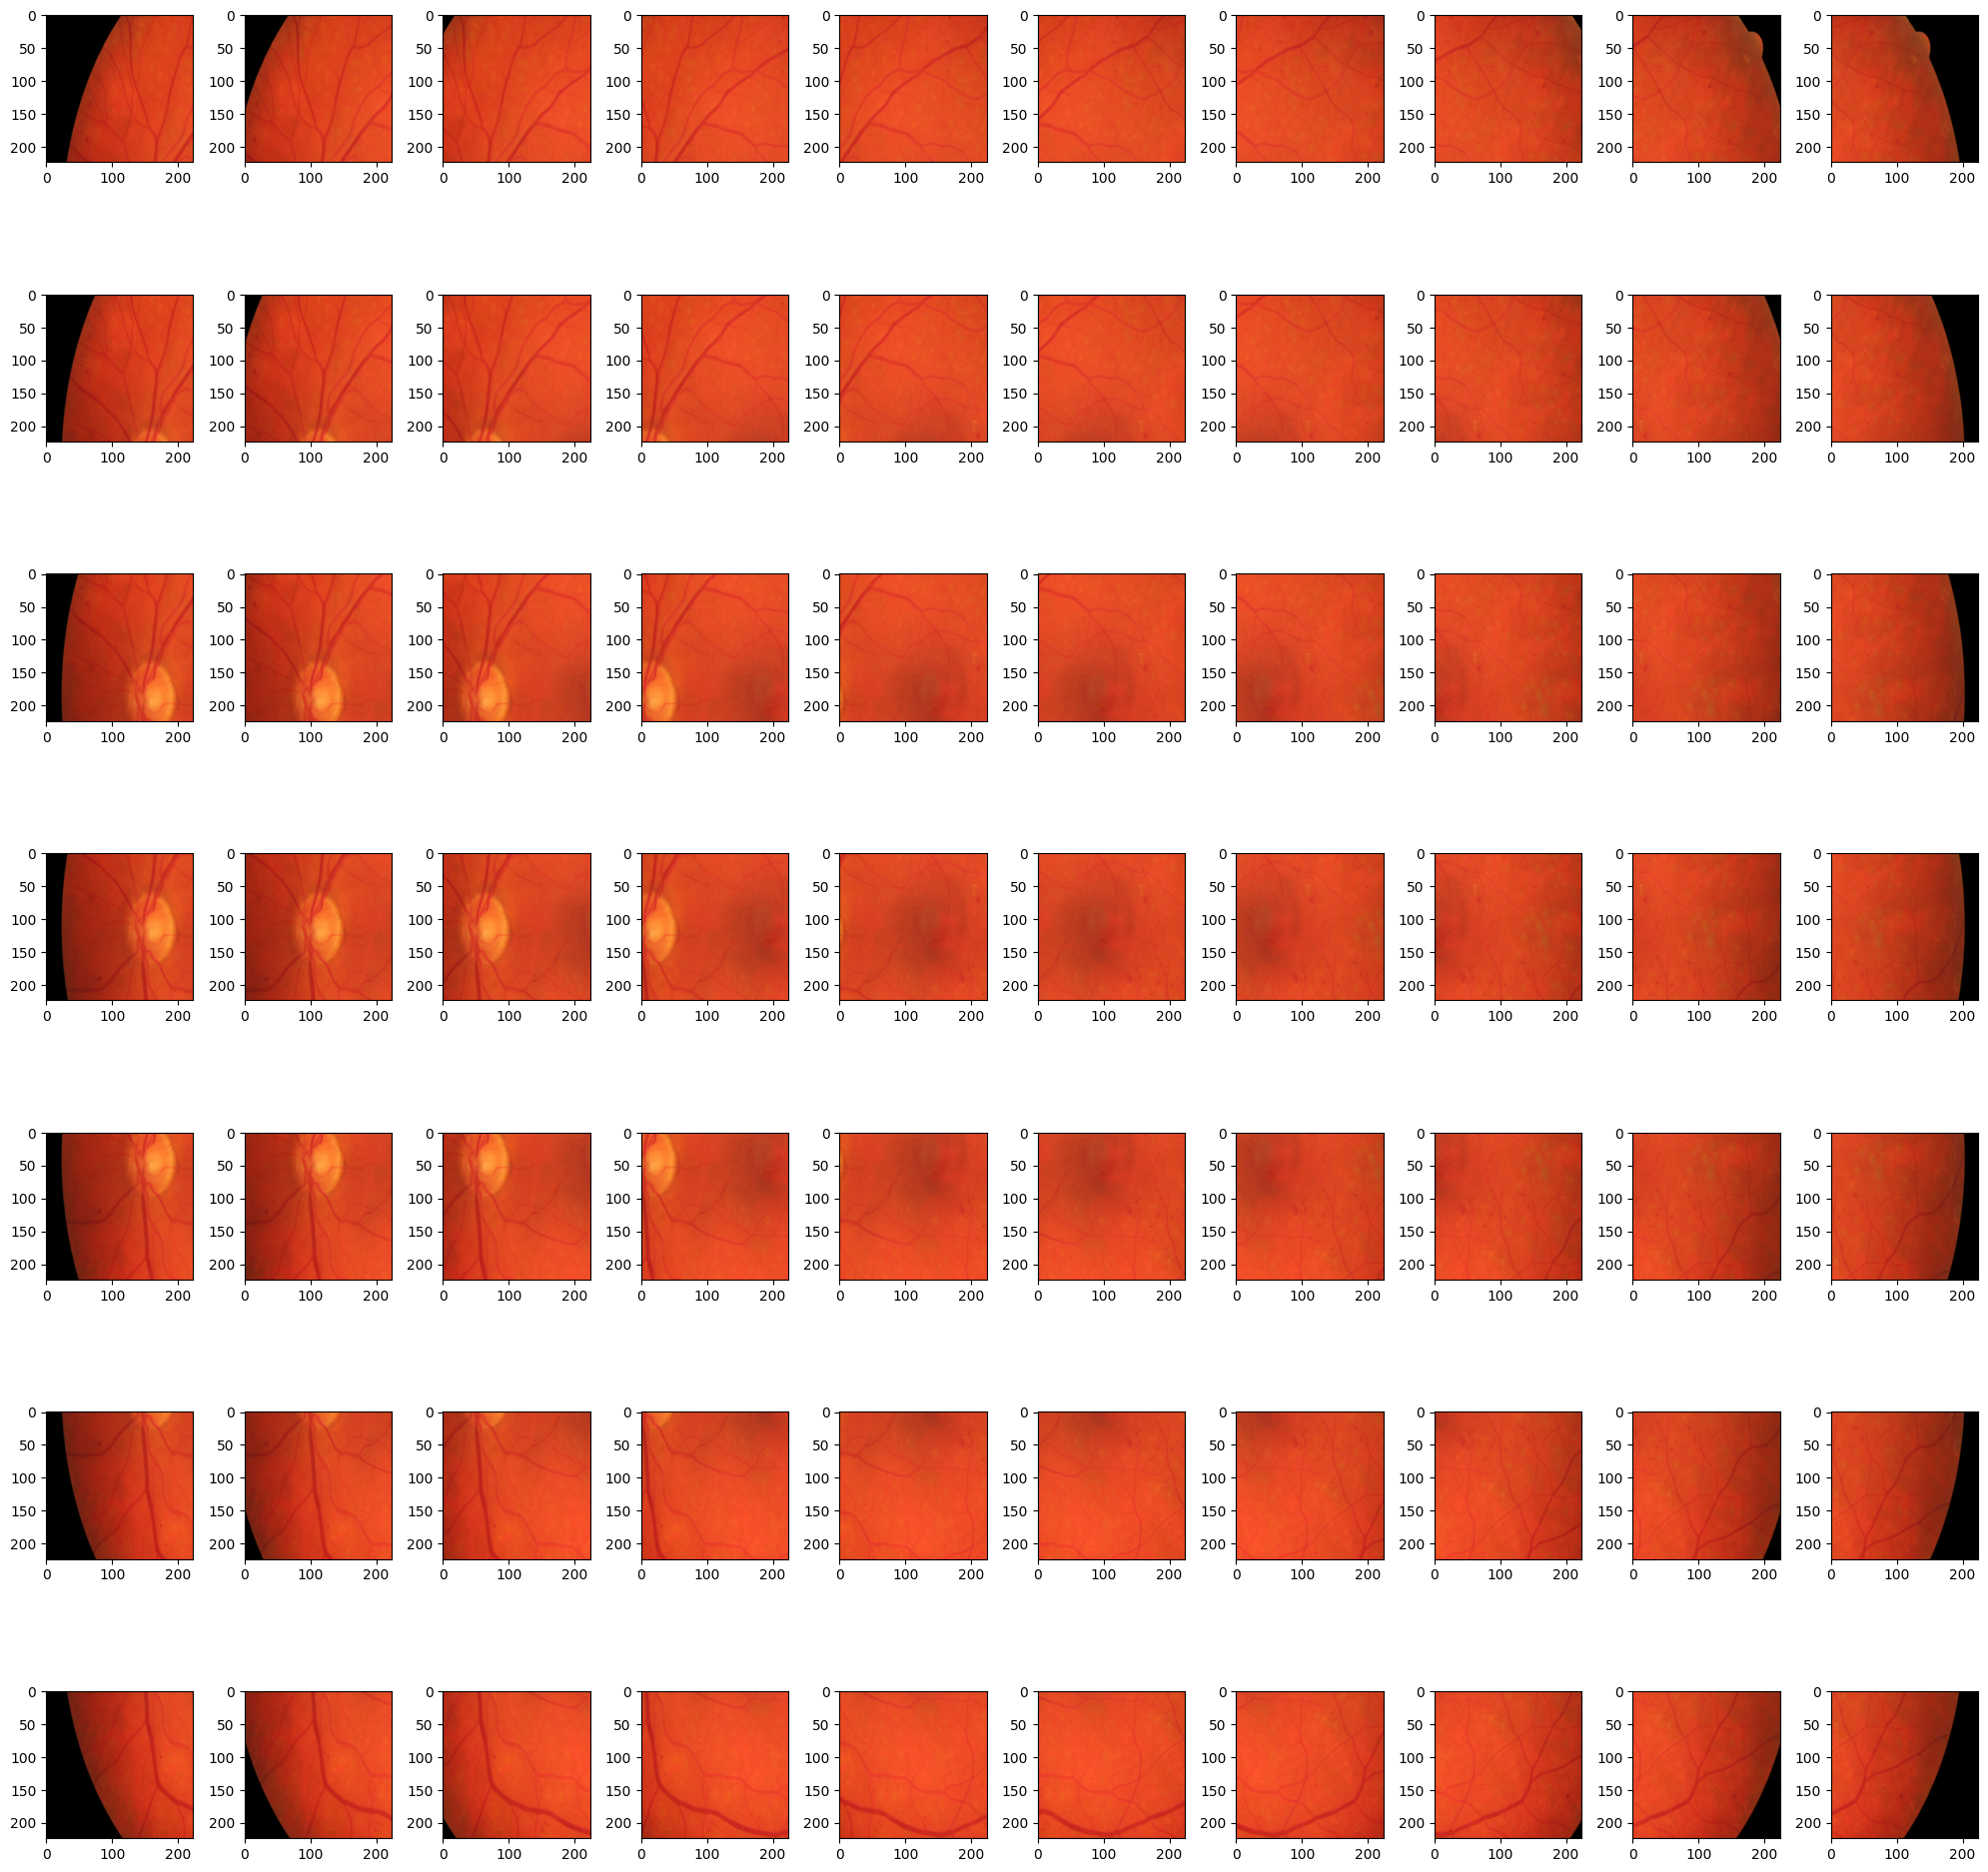

In [7]:
plt.rcParams['figure.figsize'] = (20,20)
for i in range(70):
    plt.subplot(7,10,i+1)
    plt.imshow(rgb[i])
plt.tight_layout()
plt.savefig('patches.jpg', dpi=600)

In [8]:
rgb = np.load('./training_data/vessels_seg.npy')

In [11]:
plt.rcParams['figure.figsize'] = (20,20)
for i in range(70):
    plt.subplot(7,10,i+1)
    plt.imshow(rgb[i], cmap='Greys_r')
plt.tight_layout()
plt.savefig('patches_vsi.jpg', dpi=600)

In [12]:
rgb[0].shape

(224, 224)

In [13]:
np.save('vessels_seg_1.npy', rgb[0])

In [26]:
import numpy as np

In [8]:
from skimage.transform import resize
def load_images_from_folder(folder, file_names):
    images = []
    for filename in file_names:
        img_path = os.path.join(folder, filename)
        if os.path.isfile(img_path):
            img = imageio.imread(img_path)
            images.append(img)
    return images

In [2]:
import os
tda_dir = 'tda_vr'
tda_files = sorted(os.listdir(tda_dir))

In [5]:
sorted_filenames_corrected = sorted(tda_files[1:], key=lambda x: int(x.split('.')[0]))

In [6]:
tda_files

['.ipynb_checkpoints',
 '0.jpg',
 '1.jpg',
 '10.jpg',
 '100.jpg',
 '1000.jpg',
 '1001.jpg',
 '1002.jpg',
 '1003.jpg',
 '1004.jpg',
 '1005.jpg',
 '1006.jpg',
 '1007.jpg',
 '1008.jpg',
 '1009.jpg',
 '101.jpg',
 '1010.jpg',
 '1011.jpg',
 '1012.jpg',
 '1013.jpg',
 '1014.jpg',
 '1015.jpg',
 '1016.jpg',
 '1017.jpg',
 '1018.jpg',
 '1019.jpg',
 '102.jpg',
 '1020.jpg',
 '1021.jpg',
 '1022.jpg',
 '1023.jpg',
 '1024.jpg',
 '1025.jpg',
 '1026.jpg',
 '1027.jpg',
 '1028.jpg',
 '1029.jpg',
 '103.jpg',
 '1030.jpg',
 '1031.jpg',
 '1032.jpg',
 '1033.jpg',
 '1034.jpg',
 '1035.jpg',
 '1036.jpg',
 '1037.jpg',
 '1038.jpg',
 '1039.jpg',
 '104.jpg',
 '1040.jpg',
 '1041.jpg',
 '1042.jpg',
 '1043.jpg',
 '1044.jpg',
 '1045.jpg',
 '1046.jpg',
 '1047.jpg',
 '1048.jpg',
 '1049.jpg',
 '105.jpg',
 '1050.jpg',
 '1051.jpg',
 '1052.jpg',
 '1053.jpg',
 '1054.jpg',
 '1055.jpg',
 '1056.jpg',
 '1057.jpg',
 '1058.jpg',
 '1059.jpg',
 '106.jpg',
 '1060.jpg',
 '1061.jpg',
 '1062.jpg',
 '1063.jpg',
 '1064.jpg',
 '1065.jpg',
 '10

In [9]:
tda = load_images_from_folder(tda_dir, sorted_filenames_corrected)

/var/folders/k5/7nk1477d5z3bkqm2lvczvt000000gn/T/ipykernel_68468/3432250345.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)


In [10]:
tda_res = [resize(tda[i], (224,224)) for i in range(len(tda))]

In [11]:
len(tda)

3150

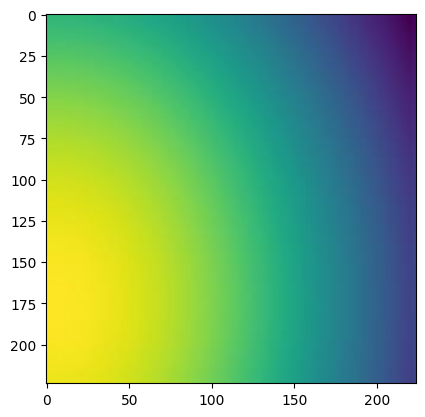

In [12]:
plt.imshow(tda_res[20])

In [13]:
tda_array = np.array(tda_res)

In [14]:
tda_array.shape

(3150, 224, 224, 3)

In [15]:
np.save('./training_data/tda_vr.npy', tda_array)